<a href="https://colab.research.google.com/github/xuanthang482/112/blob/master/helmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/mydrive', True)

Mounted at /mydrive


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


Using TensorFlow backend.


In [4]:
import os
path = '/mydrive/My Drive/Machine learning project/'
filenames=os.listdir(path)

In [5]:
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='1':
        categories.append('1')
    else:
        categories.append('0')
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
df

,filename,category
0,0.18521344-2.jpg,0
1,0.18521344-1.jpg,0
2,1.18521344-4.jpg,1
3,1.18521344-3.jpg,1
4,1.18521344-5.jpg,1
...,...,...
362,0.18521391 (1).jpg,0
363,0.18521391 (14).jpg,0
364,0.18521391 (19).jpg,0
365,0.18521391 (15).jpg,0


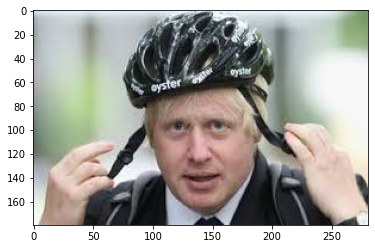

In [7]:
sample = random.choice(filenames)
image = load_img(path+sample)
plt.imshow(image)

In [8]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [9]:
train_df, validate_df = train_test_split(df, test_size=0.15)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=90,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    path, 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 311 validated image filenames belonging to 2 classes.


In [11]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    path, 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 56 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


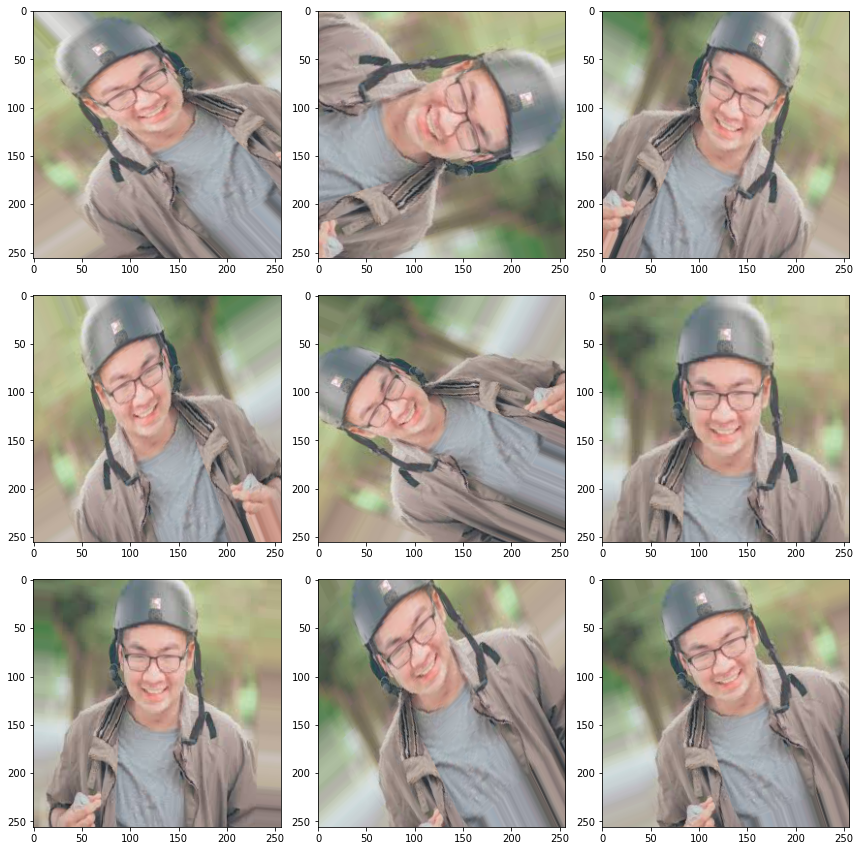

In [30]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    path, 
    x_col='filename',
    y_col='category',
  
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [13]:
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/20
19/19 [==============================] - 176s 9s/step - loss: 0.9161 - accuracy: 0.5186 - val_loss: 0.6163 - val_accuracy: 0.6875
Epoch 2/20
19/19 [==============================] - 30s 2s/step - loss: 0.8044 - accuracy: 0.5390 - val_loss: 0.5807 - val_accuracy: 0.7250
Epoch 3/20
19/19 [==============================] - 23s 1s/step - loss: 0.6954 - accuracy: 0.6020 - val_loss: 0.5153 - val_accuracy: 0.7500
Epoch 4/20
19/19 [==============================] - 22s 1s/step - loss: 0.5953 - accuracy: 0.6983 - val_loss: 0.5108 - val_accuracy: 0.8750
Epoch 5/20
19/19 [==============================] - 20s 1s/step - loss: 0.5569 - accuracy: 0.6818 - val_loss: 0.3724 - val_accuracy: 0.8750
Epoch 6/20
19/19 [==============================] - 23s 1s/step - loss: 0.5501 - accuracy: 0.7039 - val_loss: 0.3677 - val_accuracy: 0.8250
Epoch 7/20
19/19 [==============================] - 22s 1s/step - loss: 0.4661 - accuracy: 0.7972 - val_loss: 0.3031 - val_accuracy: 0.9750
Epoch 8/20
19/19 [=

In [31]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.958333  ;  loss = 0.174213 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  from ipykernel import kernelapp as app


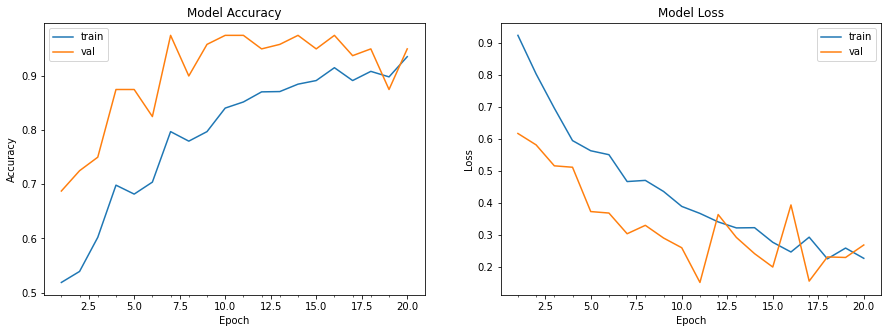

In [32]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [33]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(validate_df['category'])
labels

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])

In [34]:
#Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [35]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)

In [36]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(labels, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.22      0.22      0.22        18
           1       0.63      0.63      0.63        38

    accuracy                           0.50        56
   macro avg       0.43      0.43      0.43        56
weighted avg       0.50      0.50      0.50        56



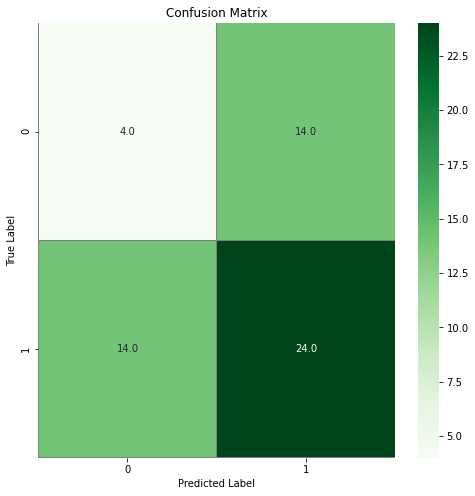

In [37]:

import seaborn as sns
from sklearn.metrics import confusion_matrix# compute the confusion matrix
confusion_mtx = confusion_matrix(labels, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [38]:
path2 = '/mydrive/My Drive/testdata/'

In [39]:
test_filenames = os.listdir(path2)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [40]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    path2, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 27 validated image filenames.


In [41]:
test_generator

In [42]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

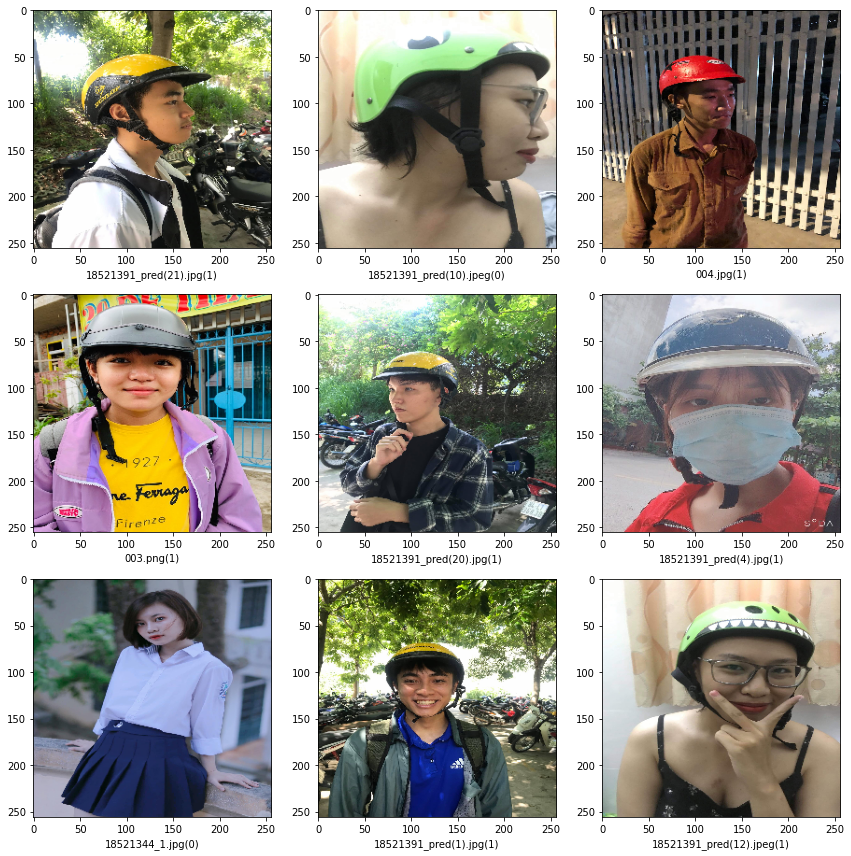

In [44]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(path2+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()